# Import packages

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
from scipy.stats import randint as sp_randint
import pickle

# Unpickle engineered features

In [12]:
unpickled_df = pd.read_pickle("./engineered_data.pkl")

# Mark each essay with its scoring scale

In [13]:
trainingdata = unpickled_df
DivSeries = pd.DataFrame({'div': [12,5,3,3,4,4,25,50],'essay_set':[1,2,3,4,5,6,7,8]})
trainingdata = trainingdata.merge(DivSeries, on='essay_set')
cols_at_end = ['score']
trainingdata = trainingdata[[c for c in trainingdata if c not in cols_at_end] + [c for c in cols_at_end if c in trainingdata]]
trainingdata = trainingdata.dropna()

# Split into train and test data

In [14]:
traincomp, testcomp = train_test_split(trainingdata,random_state=42,test_size=0.2)

set_train = traincomp.loc[:,['essay_set','essay_id','div']]  # setting asside essay set and scale
set_test = testcomp.loc[:,['essay_set','essay_id','div']] # setting asside essay set and scale

x_train = np.asarray(traincomp.iloc[:,:-3])
y_train = np.reshape(np.asarray(traincomp.loc[:,['score']]),(-1,))

x_test = np.asarray(testcomp.iloc[:,:-3])
y_test = np.reshape(np.asarray(testcomp.loc[:,['score']]),(-1,))

# Specify and fit models

In [15]:
lr = LinearRegression(fit_intercept=True)
rf = RandomForestRegressor(n_estimators=500, min_samples_split=10, min_samples_leaf=3, max_features='auto',max_depth=44, bootstrap=True, random_state=42)
sv = svm.SVR(kernel='rbf',C=0.1,gamma='scale')

In [16]:
# lr.fit(x_train, y_train)
rf.fit(x_train, y_train)
# sv.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=44,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

# Define metrics for evaluation

In [7]:
def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

def evaluate(model, x_test, y_test, div, essay_set):
    predictions = model.predict(x_test)
    y_rescaled = y_test * div
    y_rescaled = y_rescaled.astype(int)
    predictions_rescaled = predictions * div
    predictions_round = predictions_rescaled.round()
    predictions_round = predictions_round.astype(int)
    rmse = RMSE(y_rescaled, predictions_round)
    cohen = cohen_kappa_score(y_rescaled, predictions_round, weights=None)
    quad_cohen = cohen_kappa_score(y_rescaled, predictions_round, weights='quadratic')
    accuracy = accuracy_score(y_rescaled, predictions_round)
    return {'rmse':rmse,'kappa':cohen,'quad_kappa':quad_cohen,'accuracy':accuracy}

# Score models

In [8]:
# lr_metrics = evaluate(lr,x_test,y_test,div=set_test.loc[:,'div'],essay_set=set_test.loc[:,'essay_set'])
rf_metrics = evaluate(rf,x_test,y_test,div=set_test.loc[:,'div'],essay_set=set_test.loc[:,'essay_set'])
# sv_metrics = evaluate(sv,x_test,y_test,div=set_test.loc[:,'div'],essay_set=set_test.loc[:,'essay_set'])
# print("Linear Regression RMSE: {0} Cohen Kappa: {1} Cohen QW-Kappa: {2} Accuracy: {3}".format(lr_metrics['rmse'], lr_metrics['kappa'],lr_metrics['quad_kappa'],lr_metrics['accuracy']))
print("Random Forests RMSE: {0} Cohen Kappa: {1} Cohen QW-Kappa: {2} Accuracy: {3}".format(rf_metrics['rmse'], rf_metrics['kappa'], rf_metrics['quad_kappa'],rf_metrics['accuracy']))
# print("Support Vector RMSE: {0} Cohen Kappa: {1} Cohen QW-Kappa: {2} Accuracy: {3}".format(sv_metrics['rmse'], sv_metrics['kappa'],sv_metrics['quad_kappa'],sv_metrics['accuracy']))

Random Forests RMSE: 1.544162425492216 Cohen Kappa: 0.46794554676287736 Cohen QW-Kappa: 0.9847732657647326 Accuracy: 0.5354391371340523


# Score models by essay set

In [9]:
rf_scoring_df = pd.DataFrame([y_test,set_test.loc[:,'essay_set'],set_test.loc[:,'div'],rf.predict(x_test)]).transpose()
rf_scoring_df.columns = ['actual','essay_set','div','prediction']

lr_scoring_df = pd.DataFrame([y_test,set_test.loc[:,'essay_set'],set_test.loc[:,'div'],lr.predict(x_test)]).transpose()
lr_scoring_df.columns = ['actual','essay_set','div','prediction']

sv_scoring_df = pd.DataFrame([y_test,set_test.loc[:,'essay_set'],set_test.loc[:,'div'],sv.predict(x_test)]).transpose()
sv_scoring_df.columns = ['actual','essay_set','div','prediction']

def essay_set_metrics(df):
    df['y_rescaled'] = df.actual * df['div']
    df.y_rescaled = df.y_rescaled.astype(int)
    df['prediction_rescaled'] = df.prediction * df['div']
    df['prediction_round'] = df.prediction_rescaled.round()
    df.prediction_round = df.prediction_round.astype(int)
    set_df = pd.DataFrame(columns=['essay_set','RMSE','Normalized RMSE','Kappa','QW_Kappa','Accuracy'])
    e_sets = np.unique(df.essay_set)
    for e_s in e_sets:
        df_s = df[df.essay_set == e_s]
        original_score = df_s.y_rescaled.values
        predicted_score = df_s.prediction_round.values
        rmse = RMSE(original_score,predicted_score)
        norm_rmse = RMSE(df_s.actual, df_s.prediction)
        kappa = cohen_kappa_score(original_score,predicted_score, weights=None)
        quad_kappa = cohen_kappa_score(original_score,predicted_score, weights='quadratic')
        accuracy = accuracy_score(original_score,predicted_score)
        set_df = set_df.append({'essay_set':e_s,'RMSE':rmse,'Normalized RMSE':norm_rmse,'Kappa':kappa,'QW_Kappa':quad_kappa,'Accuracy':accuracy},
                             ignore_index=True)
    return set_df


print(essay_set_metrics(lr_scoring_df))
print(essay_set_metrics(rf_scoring_df))
print(essay_set_metrics(sv_scoring_df))

   essay_set      RMSE  Normalized RMSE     Kappa  QW_Kappa  Accuracy
0        1.0  1.113749         0.089623  0.185354  0.655447  0.374317
1        2.0  0.685994         0.125353  0.341279  0.567920  0.598930
2        3.0  0.689962         0.208260  0.338168  0.541992  0.577844
3        4.0  0.679052         0.209461  0.364771  0.599695  0.586111
4        5.0  0.623222         0.144039  0.438439  0.726207  0.620290
5        6.0  0.755929         0.176397  0.275904  0.543264  0.558201
6        7.0  3.162278         0.125698  0.049620  0.698724  0.115894
7        8.0  6.778024         0.133548  0.032291  0.359403  0.080292
   essay_set      RMSE  Normalized RMSE     Kappa  QW_Kappa  Accuracy
0        1.0  0.837965         0.064868  0.337946  0.814315  0.500000
1        2.0  0.573478         0.104104  0.525508  0.697749  0.708556
2        3.0  0.667913         0.192468  0.431603  0.610735  0.631737
3        4.0  0.654047         0.188721  0.451525  0.696475  0.627778
4        5.0  0.5970

# Mean quadratic weighted kappa

In [10]:
print("Linear Regression Average Quadratic Weighted Kappa ", np.mean(essay_set_metrics(lr_scoring_df)['QW_Kappa']))
print("Random Forest Average Quadratic Weighted Kappa ", np.mean(essay_set_metrics(rf_scoring_df)['QW_Kappa']))
print("Support Vector Regression Average Quadratic Weighted Kappa ", np.mean(essay_set_metrics(sv_scoring_df)['QW_Kappa']))

Linear Regression Average Quadratic Weighted Kappa  0.5865813419549195
Random Forest Average Quadratic Weighted Kappa  0.7064699998941258
Support Vector Regression Average Quadratic Weighted Kappa  0.5624911498540449


# Feature importance

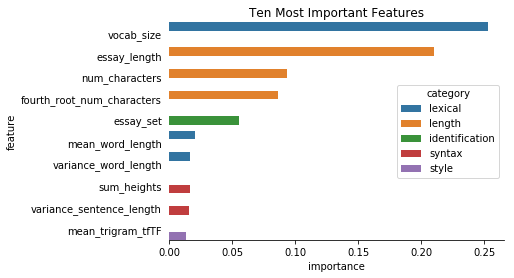

In [11]:
import pylab as plt
import seaborn as sns


feature_dict = {
    'lexical':['words_length_4','words_length_6','words_length_8','words_length_10','words_length_12','mean_word_length','variance_word_length','type_token_ratio','vocab_size'],
    'length':['essay_length','num_words','num_sentences','mean_sentence_length','num_characters','fourth_root_num_characters'],
    'occurence':['num_commas','num_periods','num_exclaim','num_question','num_semicolon','num_colon'],
    'style':['mean_trigram_tfTF', 'mean_fourgram_tfTF','pos_trigram_ratio','pos_fourgram_ratio','yules_k','connectives'],
    'syntax':['max_height','var_height','very_short_sentences','short_sentences','medium_sentences','long_sentences','variance_sentence_length','max_height','sum_heights','mean_height'],
    'reading_score':['flesch_kincaid_grade_level', 'flesch_reading_ease','gunning_fog_index', 'coleman_liau_index','automated_readability_index', 'lix', 'gulpease_index','wiener_sachtextformel'],
    'identification':['essay_set']
               }
d = dict()
for key, value in feature_dict.items():
    for item in value:
        d[item] = key
    
feature_importances = pd.DataFrame(rf.feature_importances_, index = trainingdata.columns[:-3], columns=['importance']).sort_values('importance',ascending=False)
feature_importances['rank'] = np.argsort(-feature_importances.importance)
feature_importances['feature'] = feature_importances.index
feature_importances['category'] = feature_importances['feature'].map(d)
feature_plot_data = feature_importances[feature_importances['rank'] < 10]
feature_plot_data



fig, ax = plt.subplots()

g = sns.barplot(x='importance', y='feature', hue='category', ax=ax, data=feature_plot_data)
# g = sns.catplot(x='importance', y='feature', hue='category', data=feature_plot_data,
#                 height=5, kind="bar")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

change_width(ax, .4)
plt.title("Ten Most Important Features")
sns.despine(left=True)
ax.yaxis.set_ticks_position('none') 

plt.show()

fig = g.figure
fig.savefig('feature_importance.png' ,bbox_inches="tight")


In [12]:
feature_names = unpickled_df.columns.drop(['score','essay_id'])
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=feature_names, class_names=['score'], verbose=True, mode='regression')

Intercept 0.6743070606370438
Prediction_local [0.38275594]
Right: 0.4428417175821252
Intercept 0.6673915133675421
Prediction_local [0.39824401]
Right: 0.4808197319152582
Intercept 0.6026398674409055
Prediction_local [0.60483618]
Right: 0.7248385204361917
Intercept 0.5735903656335264
Prediction_local [0.68722365]
Right: 0.7325261181928105
Intercept 0.5574423083398315
Prediction_local [0.72452729]
Right: 0.8044079283513761
Intercept 0.5958070119136691
Prediction_local [0.61537234]
Right: 0.6897622527917845
Intercept 0.573303164013074
Prediction_local [0.70263228]
Right: 0.7303576407212121
Intercept 0.6753599910922647
Prediction_local [0.38371893]
Right: 0.39304071762986537
Intercept 0.6043106078798844
Prediction_local [0.60346185]
Right: 0.5002819283658952
Intercept 0.5927117683561548
Prediction_local [0.63234489]
Right: 0.6774871443131796


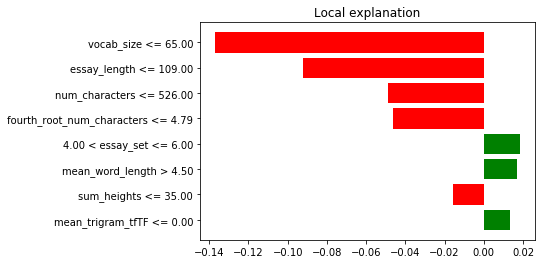

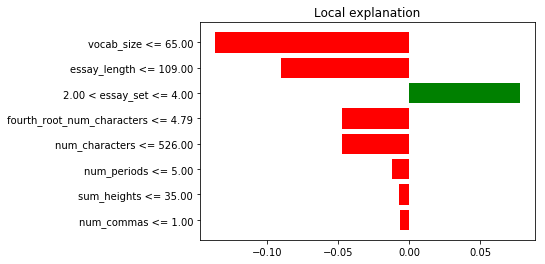

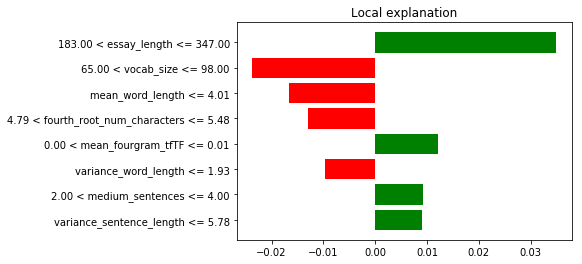

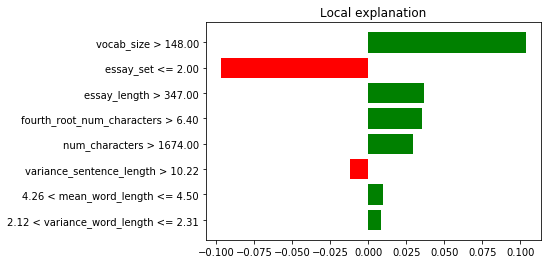

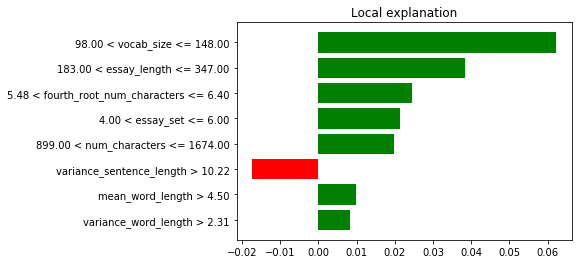

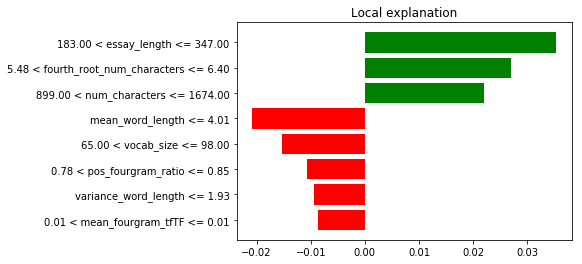

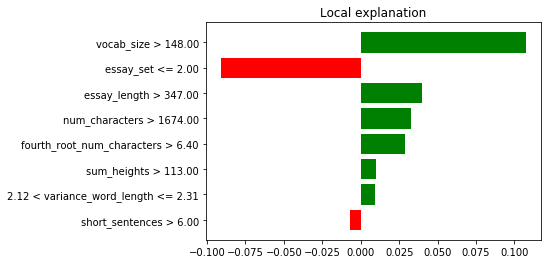

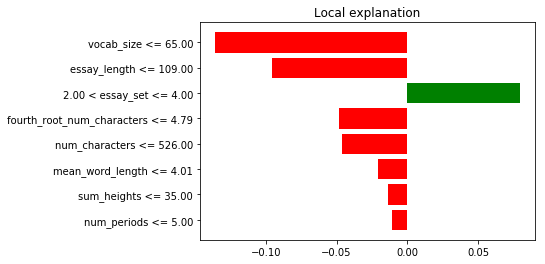

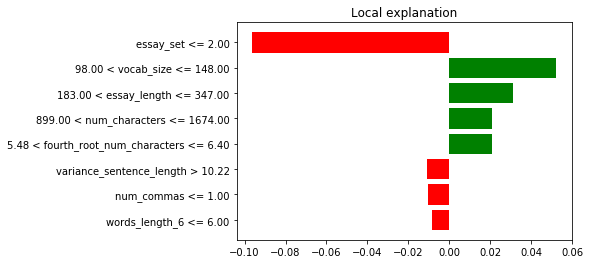

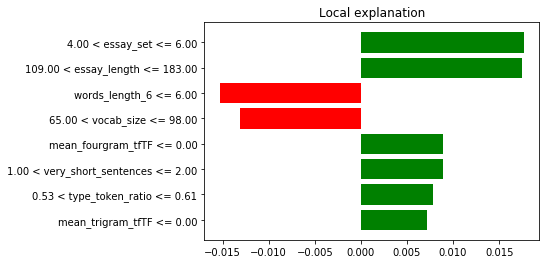

In [18]:
import random
int_list = []
for x in range (0, 10):
    int_list.append(random.randint(0, len(x_test)))

for i in int_list:
    exp = explainer.explain_instance(x_test[i], rf.predict, num_features=8)
#     exp.show_in_notebook(show_table=True)
    exp.as_pyplot_figure()

# Error Analysis

In [69]:
pred = rf.predict(x_test)
err = abs(y_test - pred)
ind = np.argpartition(err,-5)[-5:]
err_essays = set_test.iloc[ind,:]
raw_data = pd.read_excel("long_answer/training_set_rel3.xls")
err_essays_raw = raw_data[raw_data.essay_id.isin(err_essays.essay_id)]
err_essays_raw = err_essays_raw.sort_values(by='essay_id')
err_essays_feat = testcomp[testcomp.essay_id.isin(err_essays.essay_id)]
err_essays_feat = err_essays_feat.sort_values(by='essay_id')
err_full = err_essays_raw.merge(err_essays_feat, on='essay_id')

In [147]:
feature_names = unpickled_df.columns.drop(['score','essay_id'])
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=feature_names, class_names=['score'], verbose=True, mode='regression')

In [150]:
err_essays_feat_only = err_essays_feat.drop(['essay_id','div','score'], axis=1)
for i in range(len(err_essays_feat_only)):
    print(i)
    print("Actual Score: ", err_full.iloc[i,-1])
    print(err_full.iloc[i,2])
    exp = explainer.explain_instance(err_essays_feat.iloc[i,:-3], rf.predict, num_features=8)
    exp.show_in_notebook(show_table=True)

0
Actual Score:  0.0
The cyclist in this essay was a very brave man. He had many obsticles in his journey but he still made it. Nature was most definatly not on his side that day. He had to ride his bike up and down hills several times which wears you out very quickly”. “Flat road was replaced by short rolling hills, “After he got threw the hills, he came to a sigh “ ROUGH ROAD AHEAD: DO NOT EXCEED POSTED SPEED LIMIT”.  Now he has to go through bumply roads. “At some point, tumbleweeds crossed my path and a ridiculously large snake- it really did look like a diamond back-blocked the majority of the pavement in front of me”. Now the poor guy had to deal with snakes bigger than him! Thankfully he got by the snake, alive. “Over one long cripping hill, a building came into view”. The man thinks he found someplace to get water, but its an abonded building . “...,by the looks of it – and been a welch’s grape Juice Factory and botting plant.”.
Intercept 0.5546677127459971
Prediction_local [0.

1
Actual Score:  0.0
There are many reasons the narrator could have ended with this paragraph. One reason it's the start of the winter so hibiscus won't return until spring. Also, it’s the end of the story so it’s a good way to end it because it’s the ending of the hibiscus and the ending of the story. The last paragraph also kind of summarizes up the story and it’s short and sweet. Which makes it a great ending to the story. It’s not like most endings to a story so it’s unique. Because most stories aren’t about nature. In conclusion, there are many reasons the narrator could have choose to end the story with this paragraph.
Intercept 0.6171270520042357
Prediction_local [0.54929768]
Right: 0.6491978392452356


2
Actual Score:  1.0
Because she saying when the @CAPS1 grow back she will be @CAPS2 to take the test again.
Intercept 0.6733335758392116
Prediction_local [0.38400862]
Right: 0.09632123687306283


3
Actual Score:  0.0
Dirigibles also known today as Blimps used to dock at the empire state building. The Empire State building was used as a docking ground for dirigibles (which are enormous steel formed balloons filled with hydrogen and helium, which made them lighter then air). They had a top speed of @NUM1 mph for thousands of miles. "Al Smith saw an opportunity for the empire state building: A moor added to the top of the building would allow dirigibles to anchor their for several hours for refueling or service, and to let passengers on and off." As stated in the excerpt. The dirigibles were docked by an electric winch which stopped the big balloon from going anywhere and tied it to the mast. Al Smith was successful when building moore cause it was good for dirigibles.
Intercept 0.6045495960339586
Prediction_local [0.61897267]
Right: 0.6430269572007512


4
Actual Score:  0.0
Based on the excerpt, The Mooring Mast by @ORGANIZATION1, there were many challenges the builders of the Empire State building faced while they had high hopes in creating the world's tallest building. They added on hundreds of feet allowing dirigibles to dock there. Competing with the Chrysler building, Al Smith announced that the Empire State building would reach 1,250 feet beating the Chrysler Building by @NUM1 feet. Al Smith was desprite to do whatever he could to construct the world's tallest building, even to create a landing spot for dirigibles. @ORGANIZATION2's idea didn't work out as planned. Instead, the @CAPS1 assigned to dirigible passengers was made into the world's highest soda fountain and tea garden.
Intercept 0.5863586956644137
Prediction_local [0.62460336]
Right: 0.6934298084197362


# Grid search code (commented out for brevity)

In [ ]:
# # # Create the parameter grid based on the results of random search 
# param_grid = {
#     'n_estimators': [500],
#     'min_samples_split': [10, 12],
#     'min_samples_leaf': [2,3],
#     'max_features': ['auto'],
#     'max_depth': [40, 44],
#     'bootstrap': [True]  
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(x_train, y_train)

In [10]:
# grid = {
#     'kernel': ['linear','rbf'],
#     'gamma': ['auto'],
#     'C':[0.1,1]
# }

# sv = svm.SVR()

# sv_grid = GridSearchCV(estimator = sv, param_grid= grid, cv = 3, verbose=4, n_jobs = -1)
# sv_grid.fit(x_train, y_train)